In [37]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [38]:
import numpy as np
import pandas as pd

In [39]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [40]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [41]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [42]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [43]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [44]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [45]:
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [46]:
engine.execute('SELECT * FROM Station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [47]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [48]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
query_date
# Perform a query to retrieve the date and precipitation scores
precip_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= '2016-08-23').\
    order_by(Measurement.date).all()
precip_data
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_data, columns=['Date', 'Precipitation'])
precip_df.set_index('Date', inplace=True)
precip_df.head(10)
# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


Precipitation
Date                     
2016-08-23           0.00
2016-08-23           0.15
2016-08-23           0.05
2016-08-23            NaN
2016-08-23           0.02
2016-08-23           1.79
2016-08-23           0.70
2016-08-24           0.08
2016-08-24           2.15
2016-08-24           2.28

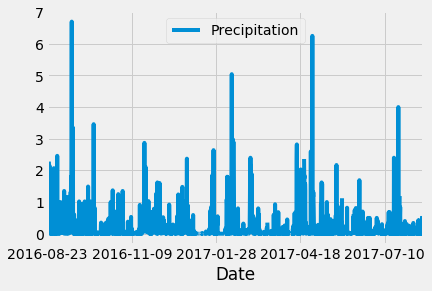

In [50]:
precip_df.plot()
plt.show()

![precipitation](Images/precipitation.png)

In [51]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

Precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000

In [54]:
# Design a query to show how many stations are available in this dataset?
stations_count= session.query(Station.station).count()
stations_count

9

In [79]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_group_count= session.query(Measurement.station,func.count(Measurement.station)).\
                                     group_by(Measurement.station).\
                                     order_by(func.count(Measurement.station).desc()).all()
stations_group_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [69]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
highobserve_station_temps = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))\
                  .filter(Measurement.station == 'USC00519281').all()
highobserve_station_temps

[(54.0, 85.0, 71.66378066378067)]

In [100]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_temp_12months = session.query(Measurement.date,Measurement.station,Measurement.tobs).\
             filter(Measurement.date >= '2016-08-23').\
             filter(Measurement.station == 'USC00519281').order_by(Measurement.date.desc()).all()
station_temp_12months = pd.DataFrame(station_temp_12months,columns=["Date","Station ID","TOBS"])
station_temp_12months.head()

Date   Station ID  TOBS
0  2017-08-18  USC00519281  79.0
1  2017-08-17  USC00519281  76.0
2  2017-08-16  USC00519281  76.0
3  2017-08-15  USC00519281  77.0
4  2017-08-14  USC00519281  77.0

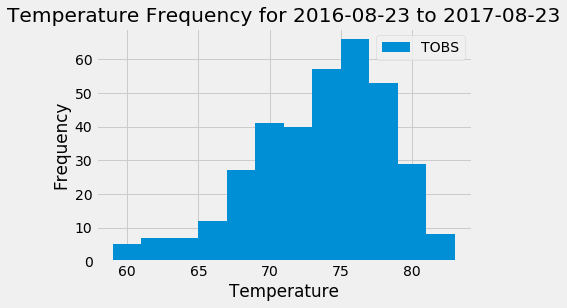

In [107]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_temp_12months.plot.hist(bins=12,label="tobs",
                                title=f'Temperature Frequency for 2016-08-23 to 2017-08-23')
plt.ylim=(0,100)
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.legend=()
plt.show()

In [108]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [110]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
Result = calc_temps('2011-02-28', '2011-03-05')
print(Result)

[(61.0, 69.75510204081633, 75.0)]


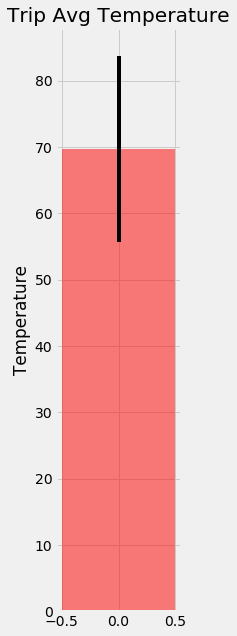

In [111]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmin = Result[0][0]
tavg = Result[0][1]
tmax = Result[0][2]
y_err = tmax-tmin

plt.figure(figsize=(2,10))
plt.bar(0,tavg,yerr=y_err,align="center",width=1,color="red",alpha=0.5)
plt.ylim=(0,100)
plt.ylabel("Temperature")
plt.title("Trip Avg Temperature")
plt.show()

In [113]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall_per_station = session.query(Measurement.station, func.sum(Measurement.prcp)).\
                       filter(Measurement.date>='2011-02-28').filter(Measurement.date<='2011-03-05').\
                       group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
rainfall_per_station

[('USC00518838', 2.33),
 ('USC00519281', 2.23),
 ('USC00519523', 2.19),
 ('USC00514830', 1.96),
 ('USC00516128', 1.45),
 ('USC00513117', 1.44),
 ('USC00519397', 1.38),
 ('USC00511918', 0.63),
 ('USC00517948', None)]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


tmin       tavg  tmax
date                             
2018-01-01  62.0  69.153846  77.0
2018-01-02  60.0  69.396226  77.0
2018-01-03  62.0  68.909091  77.0
2018-01-04  58.0  70.000000  76.0
2018-01-05  56.0  67.964286  76.0

<IPython.core.display.Javascript object>


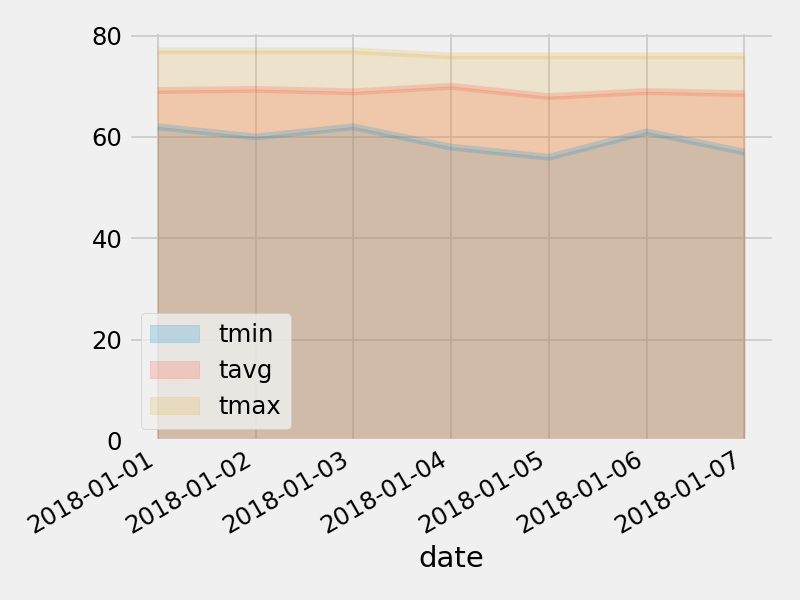

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
